In [170]:
import pandas as pd
import numpy as np
import meld
import scanpy as sc
from matplotlib import colormaps
import matplotlib.pyplot as plt
import scprep
import sklearn
import phate
import graphtools as gt
np.random.seed(42)

This notebook is used to determine the differential abundance, and thus must be executed on the integrated data. Beforehands, the data must be converted to h5ad as in the script convert.R.

In [159]:
adata = sc.read_h5ad("07_preprocessed_highDiet_normalDiet_scenario.1.h5ad")

# Get the loadings of the different reductions, the metadata and raw data as a dataframe. We will mostly be using the umap to project the data.
umap = adata.obsm["X_umap"]
pca = adata.obsm["X_pca"]
metadata = adata.obs
data = adata.to_df()

del adata

# create the affinity graph and perform the MELD algorithm on it. The beta and knn values come from the paper and were determined optimals after a benchmark by the authors.
meld_op = meld.MELD(beta = 67, knn=7)
sample_densities = meld_op.fit_transform(pca, sample_labels=metadata["orig.ident"])

Building graph on 11760 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 3.81 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 4.33 seconds.


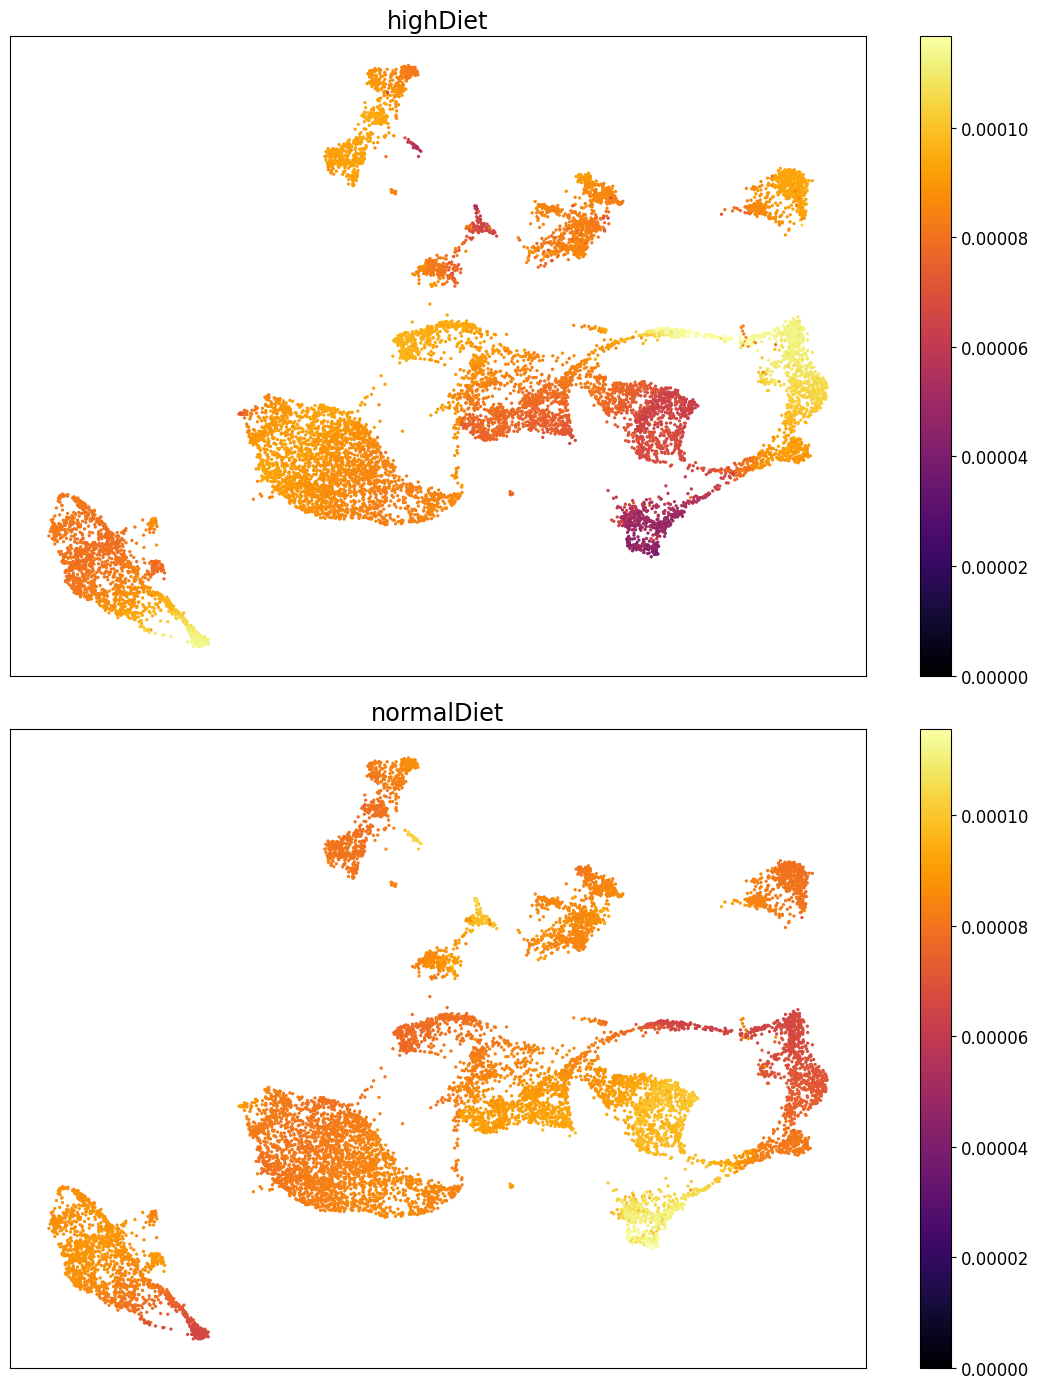

In [160]:
fig, axes = plt.subplots(2,1, figsize=(11,14))

# Display the density of the samples on the umap.
for i, ax in enumerate(axes.flatten()):
    density = sample_densities.iloc[:,i]
    scprep.plot.scatter2d(umap, c=density,
                          title=density.name,
                          vmin=0, 
                          ticks=False, ax=ax)
    

fig.tight_layout()

In [161]:
def replicate_normalize_densities(sample_densities, replicate):
    # Get the unique replicates
    replicates = np.unique(replicate)
    sample_likelihoods = sample_densities.copy()
    for rep in replicates:
        # Select the columns of `sample_densities` for that replicate
        curr_cols = sample_densities.columns[[rep in col for col in sample_densities.columns]]
        # Apply L1 normalization between the same technical replicate of the conditions. If there is no replicate, apply L1 normalization on the conditions
        sample_likelihoods[curr_cols] = sklearn.preprocessing.normalize(sample_densities[curr_cols], norm='l1')

    return sample_likelihoods

# The same technical replicates must have the same name between conditions. If there are no replicates, give a common part present in both conditions.
sample_likelihoods = replicate_normalize_densities(sample_densities, ["Diet"])


/home/benjaminl/miniconda3/envs/scell/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


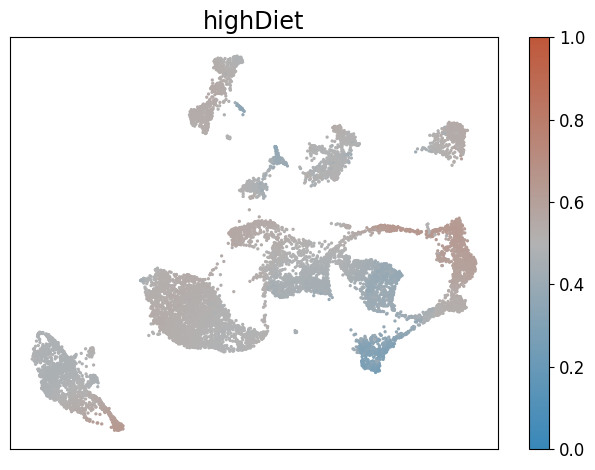

In [162]:
experimental_samples = ["highDiet"] # replicates

# Display the likelihood of cells belonging to the condition of the replicate (higher values mean higher likelihood).
# When there are only two conditions, the values of the second condition are just 1 - values of the first condition,
# which is pointless to represent.
if(len(experimental_samples) > 1):
    fig, ax = plt.subplots(1,len(experimental_samples), figsize=(13,4))

    for curr_sample, ax in zip(experimental_samples, axes):
        scprep.plot.scatter2d(umap, c=sample_likelihoods[curr_sample], cmap=meld.get_meld_cmap(),
                            vmin=0, vmax=1,
                            title=curr_sample, ticks=False, ax=ax)
        fig.tight_layout()
else:
    scprep.plot.scatter2d(umap, c=sample_likelihoods[experimental_samples[0]], cmap=meld.get_meld_cmap(),
                            vmin=0, vmax=1,
                            title=experimental_samples[0], ticks=False)


In [163]:
# Display the mean and std between replicates. Only meaningful with technical replicates in one condition.
# Low standard deviation highlight areas where the cells are similarly enriched or depleted between replicates
if(len(experimental_samples) > 1):
    fig, axes = plt.subplots(1,2, figsize=(8.7,4))

    scprep.plot.scatter2d(umap, c=sample_likelihoods[experimental_samples].mean(axis=1), 
                        cmap=meld.get_meld_cmap(), vmin=0, vmax=1,
                        title='Mean', ticks=False, ax=axes[0])
    scprep.plot.scatter2d(umap, c=sample_likelihoods[experimental_samples].std(axis=1), vmin=0, 
                        cmap='inferno', title='St. Dev.', ticks=False, ax=axes[1])

    fig.tight_layout()

In [164]:
metadata['cond_likelihood'] = sample_likelihoods[experimental_samples].mean(axis=1).values # store the mean of the condition's replicate
metadata["orig.ident"] = [1 if ident == "highDiet" else 0 for ident in metadata['orig.ident']] # Need to turn the orig idents as numbers since we compute the means later on
pred = pd.read_csv("predictions.csv", header=0)
leiden = pd.read_csv("clusters.csv", header=0)
colortable = pd.read_csv("colorsSheet.csv", header=0)
metadata["prediction"] = pred["predicted.id"].values
metadata["leiden"] = leiden["integrated_snn_res.1"].values


In [267]:
clustering = "leiden" #either leiden for the leiden clusters or prediction for the atlas-based celltypes

if clustering == "prediction":
    colors = dict(zip(colortable["celltype"],colortable["celltype_color"]))
    predcol = [colors[celltype] for celltype in metadata["prediction"]]
else:
    colors = colormaps["tab20"].resampled(len(np.unique(metadata[clustering])))

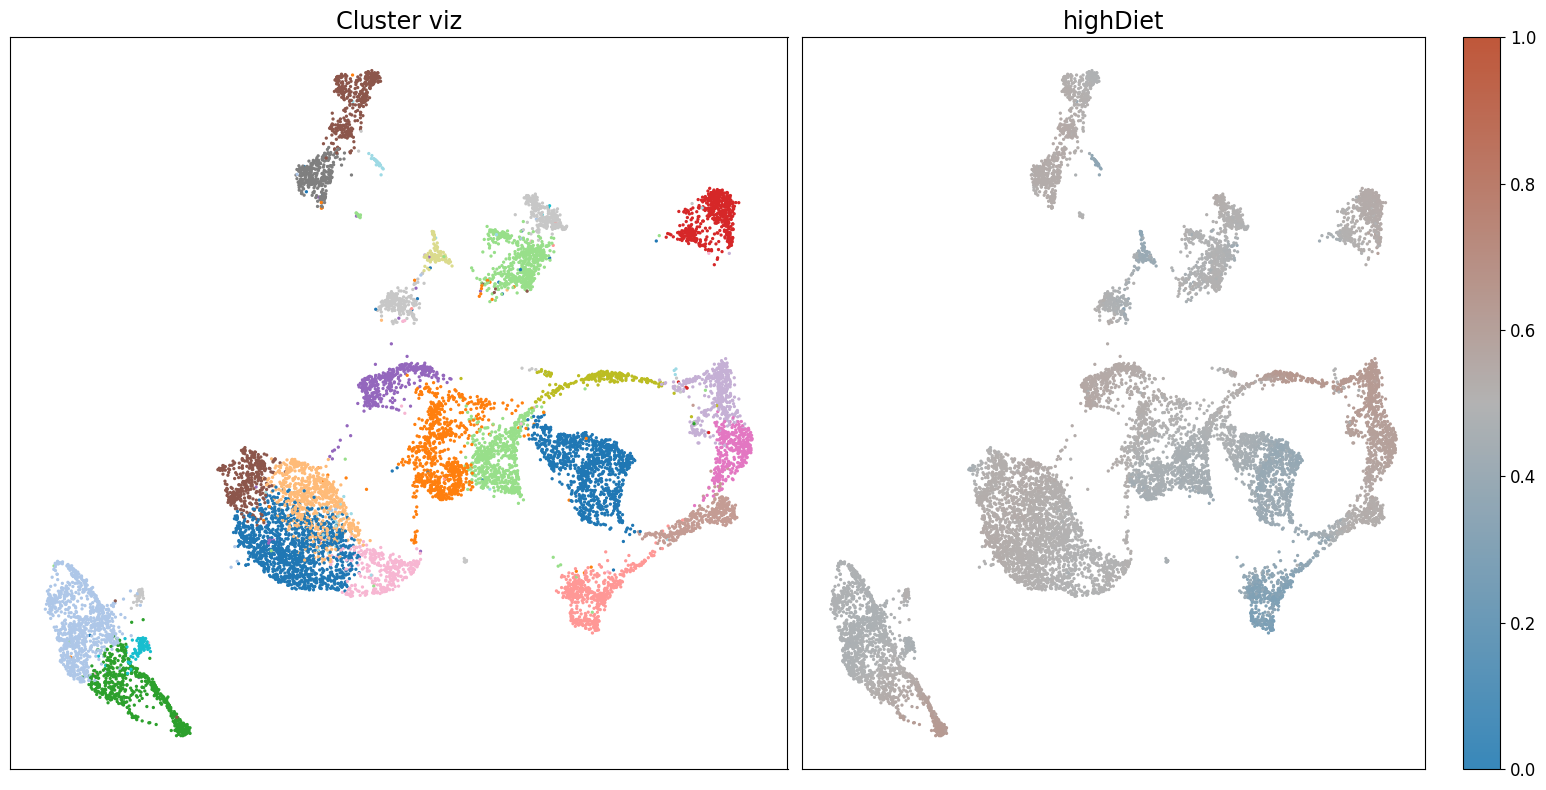

In [263]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

scprep.plot.scatter2d(umap, c=metadata[clustering], cmap=colors,
                      title='Cluster viz', ticks=False, ax=axes[0], legend=False, legend_anchor=(0,2), legend_loc="upper center") # Legend is finicky, will either try to correctly display or delete the chunk

scprep.plot.scatter2d(umap, c=sample_likelihoods["highDiet"], cmap=meld.get_meld_cmap(),
                        vmin=0, vmax=1,
                        title="highDiet", ticks=False, ax=axes[1])

fig.tight_layout()

In [208]:
#Sort the index of each cluster from lowest to highest average chd likelihood value
metadata[f"{clustering}ID"] = scprep.utils.sort_clusters_by_values(metadata[clustering], metadata["cond_likelihood"]) 

In [210]:
def plot_confidence_interval(y, values, z=1.96, thresholds=[0.5,0.5], colors=['#2187bb', "red"], vertical_line_width=0.35):
    mean = np.mean(values)
    stdev = np.std(values)
    confidence_interval = z * stdev #/ np.sqrt(len(values))
    if (mean > thresholds[1] and mean - confidence_interval > thresholds[1]) or (mean < thresholds[0] and mean + confidence_interval < thresholds[0]):
        color = colors[0]
    else:
        color = colors[1]
        
    top = y - vertical_line_width / 2
    left = mean - confidence_interval
    bottom = y + vertical_line_width / 2
    right = mean + confidence_interval
    plt.plot([left, right], [y, y], color=color)
    plt.plot([left, left], [top, bottom], color=color)
    plt.plot([right, right], [top, bottom], color=color)
    plt.plot(mean, y, "o", color="black")

    return mean, confidence_interval

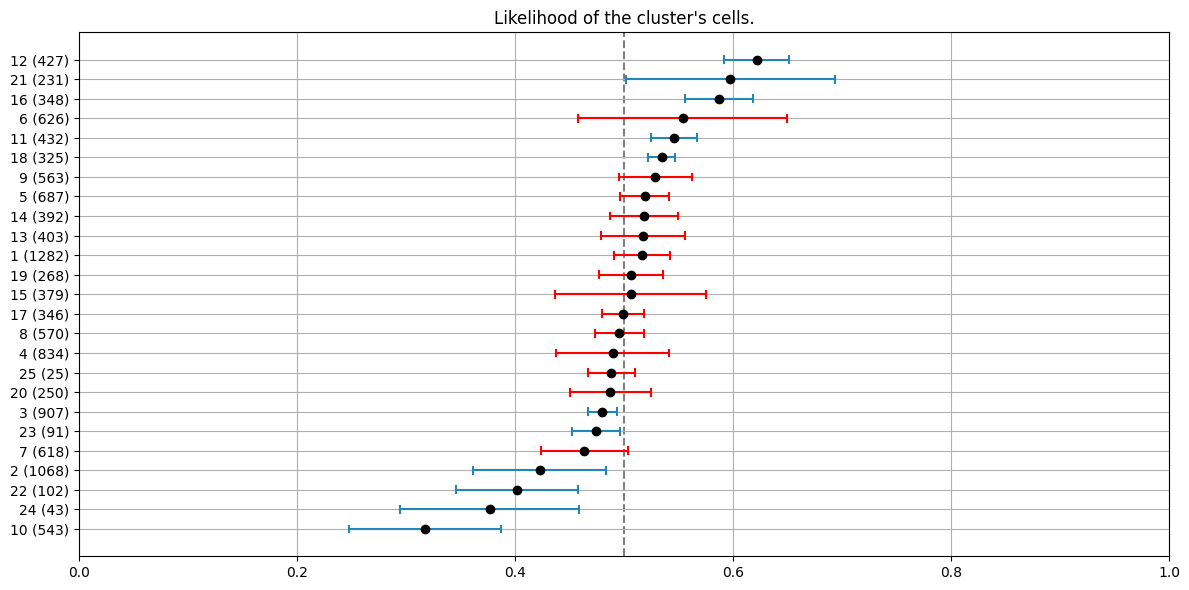

In [226]:
plt.figure(figsize = (12,6))
clusters, counts = np.unique(metadata[clustering], return_counts=True)

for pred in np.unique(metadata[f"{clustering}ID"]):
    plot_confidence_interval(pred, metadata.loc[metadata[f"{clustering}ID"] == pred, "cond_likelihood"])

plt.axvline(0.5, linestyle = '--', color='grey', zorder=0)

plt.grid(visible=True)
plt.xlim(0,1)

ylabel = [f"{clust} ({counts[list(clusters).index(clust)]})" for clust in metadata.set_index(f"{clustering}ID")[clustering].drop_duplicates()]
plt.yticks(metadata[f"{clustering}ID"].drop_duplicates(), ylabel)

plt.title("Likelihood of the cluster's cells.")
plt.tight_layout()


In [216]:
# Keep cluster labels with over one cell, otherwise the algorithm fails
clusters = clusters[counts > 1]

In [217]:
data_cluster_phate = {}

for cluster in clusters:
    curr_data = data.loc[metadata[clustering] == cluster]
    # Run phate on all clusters. Maybe try to do without it ?
    data_cluster_phate[cluster] = phate.PHATE(verbose=0).fit_transform(curr_data)

/home/benjaminl/miniconda3/envs/scell/lib/python3.11/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (91, 808) is expensive. Consider setting n_pca.
  warnings.warn(
/home/benjaminl/miniconda3/envs/scell/lib/python3.11/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (43, 808) is expensive. Consider setting n_pca.
  warnings.warn(
/home/benjaminl/miniconda3/envs/scell/lib/python3.11/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (25, 808) is expensive. Consider setting n_pca.
  warnings.warn(


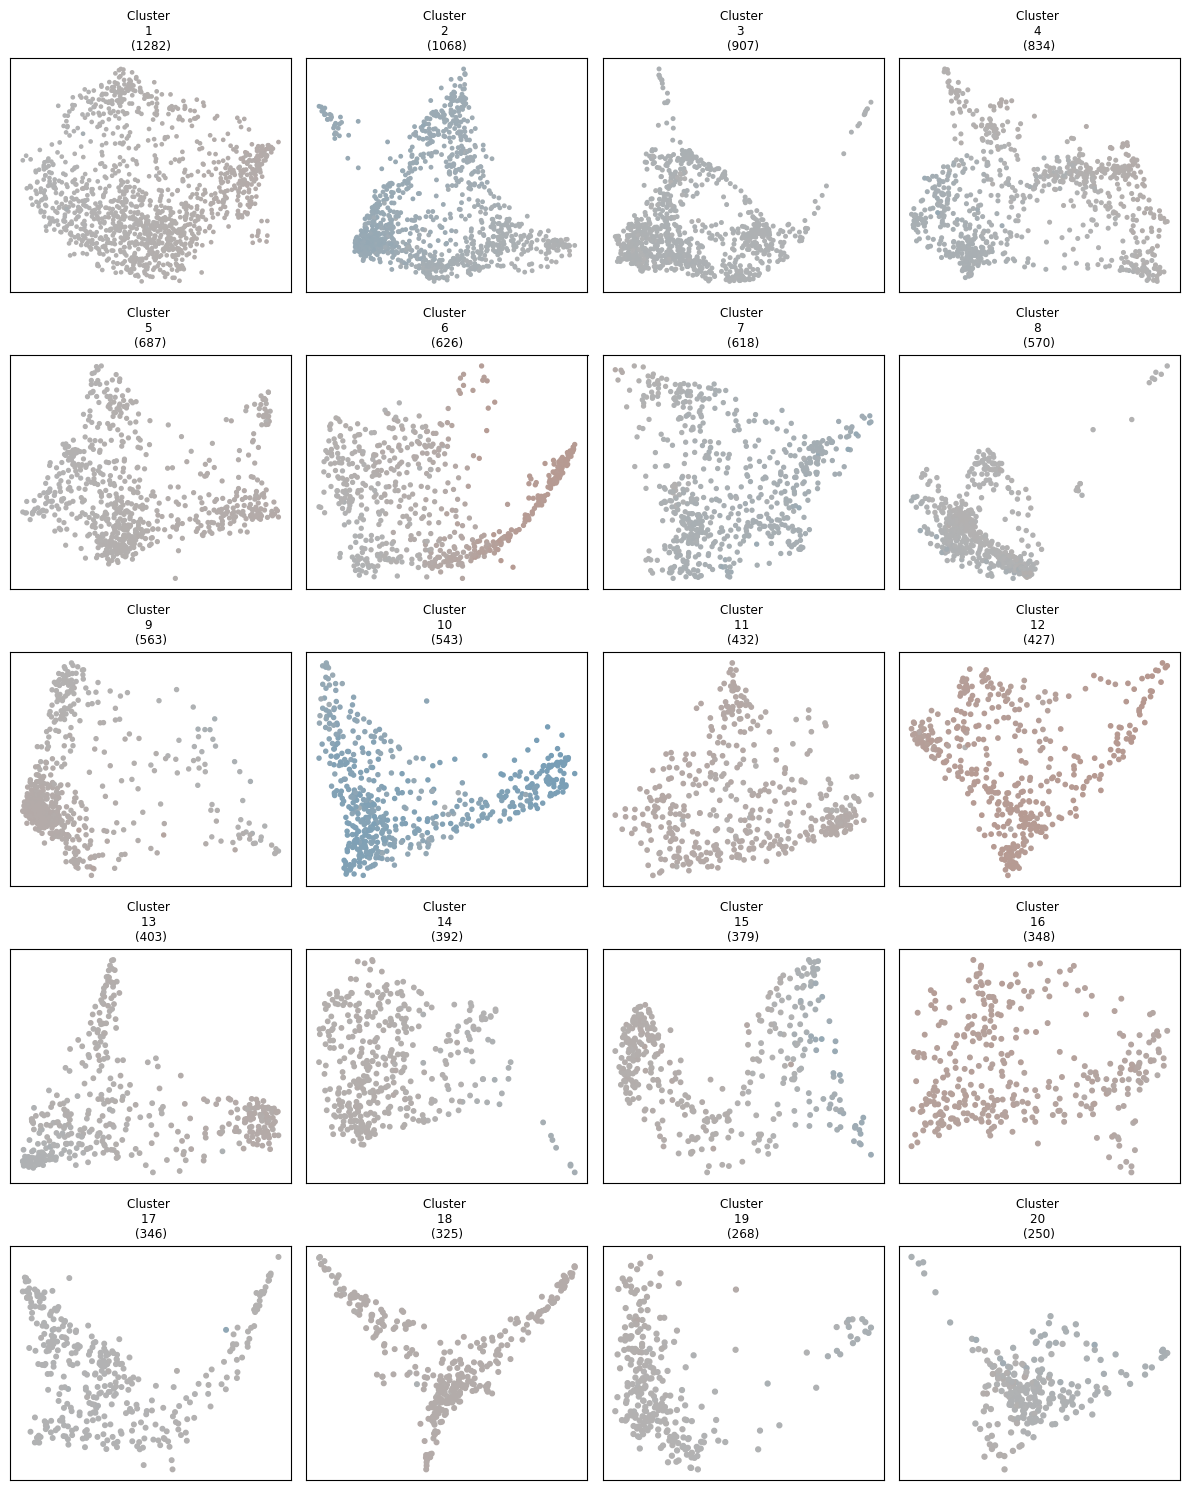

In [227]:
fig,axes= plt.subplots(5,4, figsize=(4*3, 5*3))

for i , ax in enumerate(axes.flatten()):
    if not i < len(clusters):
        ax.axis('off')
        continue
    curr_cluster = clusters[i]
    curr_phate = data_cluster_phate[curr_cluster]
    
    # Plots with different condition likelihood values can probably be subclustered using VFC
    scprep.plot.scatter2d(curr_phate, 
                          c=metadata['cond_likelihood'].loc[metadata[clustering] == curr_cluster], 
                          cmap=meld.get_meld_cmap(), vmin=0, vmax=1,
                         ax=ax, ticks=False, 
                          title='Cluster \n{} \n({})'.format(curr_cluster, curr_phate.shape[0]), 
                          legend=False, fontsize=5)
fig.tight_layout()


In [228]:
vfc_op_per_cluster = {}

ugraph = pd.DataFrame(umap, columns=["x","y"], index=metadata.index)
ugraph = ugraph.join(metadata[clustering])

for cluster in clusters:
    curr_G = gt.Graph(ugraph.loc[metadata[clustering] == cluster, ["x", "y"]], use_pygsp=True)
    curr_G.compute_fourier_basis()
    curr_sample_labels = metadata['orig.ident'].loc[metadata[clustering] == cluster]
    curr_likelihood = metadata['cond_likelihood'].loc[metadata[clustering] == cluster]
    curr_vfc = meld.VertexFrequencyCluster(n_clusters = 3)
    curr_vfc.fit_transform(curr_G, curr_sample_labels, curr_likelihood)
    vfc_op_per_cluster[cluster] = curr_vfc

In [229]:
subclustering_results = {}
for cluster in clusters:
    curr_vfc = vfc_op_per_cluster[cluster]
    clusters_by_n = {}
    for n in [2,3,4,5]:
        clusters_by_n[n] = curr_vfc.predict(n)
    subclustering_results[cluster] = clusters_by_n

In [234]:
picked_clusters = {2:2, 6:2}

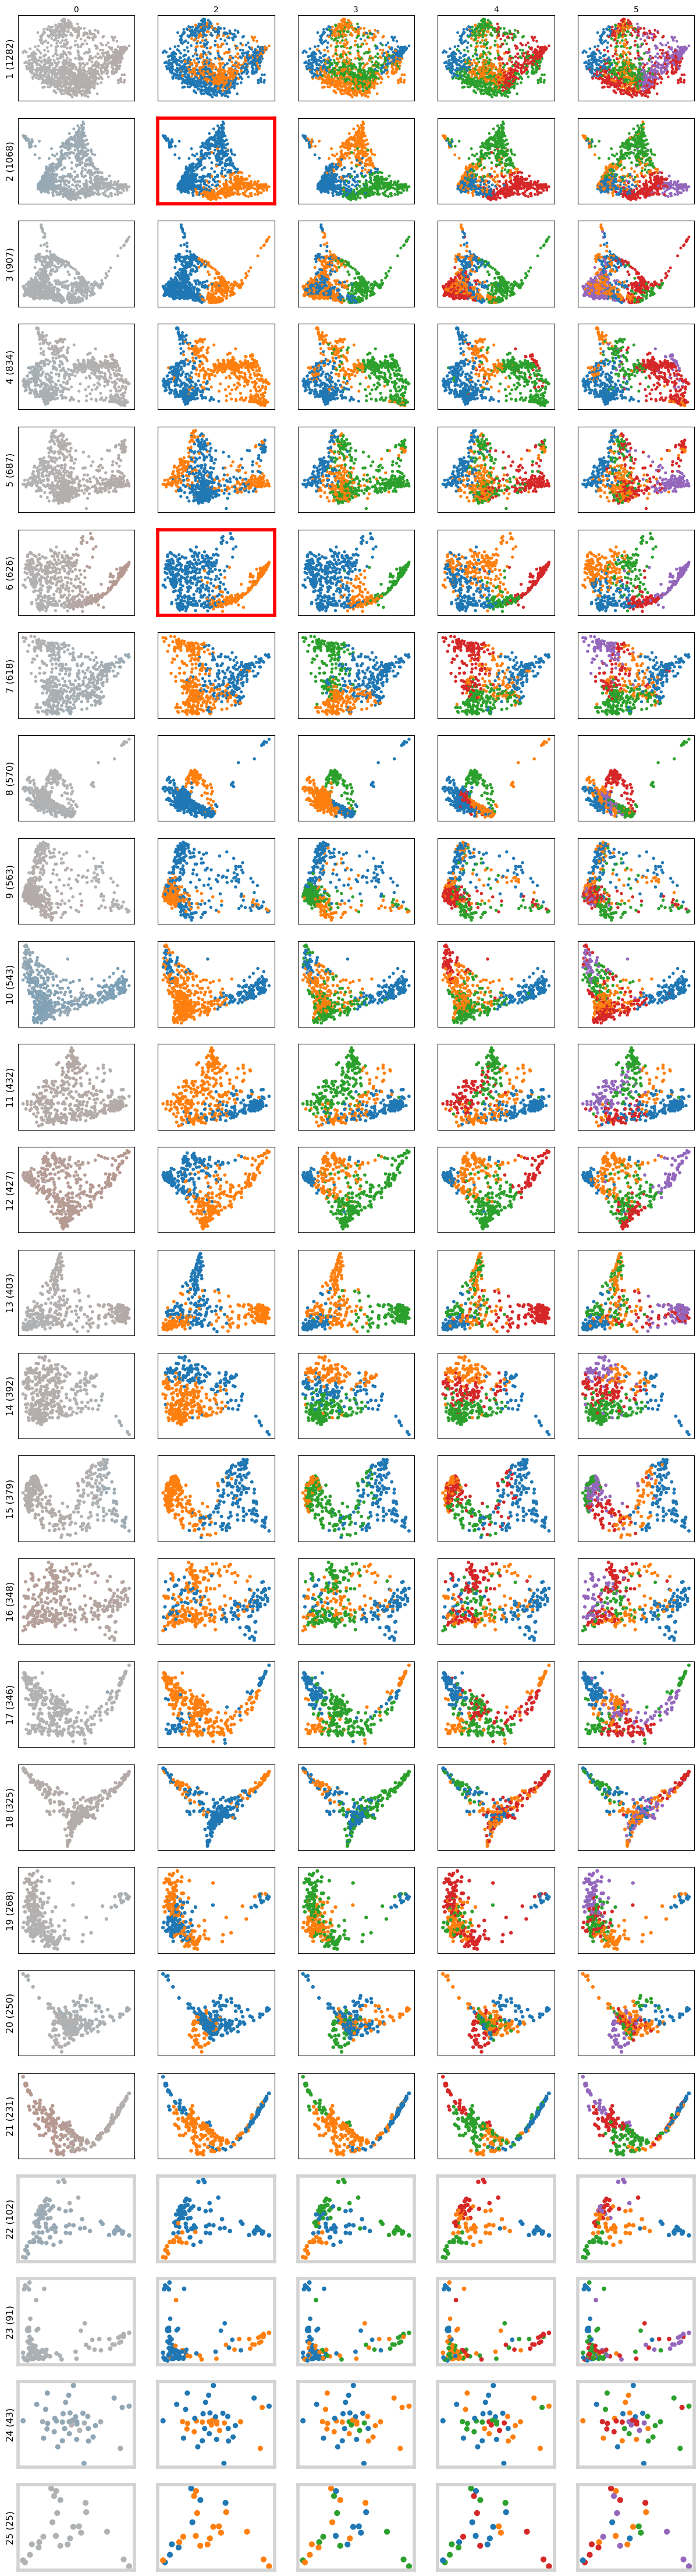

In [259]:
fig, axes= plt.subplots(25,5, figsize=(15, 19*3))

for i, r_ax in enumerate(axes):
    cluster = clusters[i]
    curr_phate = data_cluster_phate[cluster]

    for j, n in enumerate([0,2,3,4,5]):
        if i == 0:
            r_ax[j].set_xlabel(n)
            r_ax[j].xaxis.set_label_position('top')
        if j == 0:
            cvec = metadata['cond_likelihood'].loc[metadata[clustering] == cluster]
            ylabel= str(cluster) + ' ({})'.format(len(cvec))

            cmap= meld.get_meld_cmap()
            vmin=0
            vmax=1           
        else:
            cvec = subclustering_results[cluster][n]
            cmap = ylabel = vmin = vmax = None
            
        if np.sum(metadata[clustering] == cluster) < (metadata.shape[0] * 0.01):
            plt.setp(r_ax[j].spines.values(), color='lightgrey', linewidth=4)
        scprep.plot.scatter2d(curr_phate, c=cvec, cmap=cmap, vmin=vmin, vmax=vmax,
                         ax=r_ax[j], ticks=False, ylabel=ylabel, fontsize=8, legend=False)
        
        # Red outline for clusters that we decide to subcluster
        if cluster in picked_clusters:
            if picked_clusters[cluster] == n:
                plt.setp(r_ax[j].spines.values(), color='r', linewidth=4)



In [236]:
metadata['VFC'] = metadata[clustering].copy() #We use prediction ID here because we need VFC to be numbers
for curr_cluster in clusters:
    if curr_cluster not in picked_clusters:
        continue
    
    new_clusters = subclustering_results[curr_cluster][picked_clusters[curr_cluster]]
    
    metadata.loc[metadata[clustering] == curr_cluster, 'VFC'] = new_clusters + 1 + np.max(metadata['VFC'])
    
metadata['VFC'] = scprep.utils.sort_clusters_by_values(metadata['VFC'], metadata['cond_likelihood'])

In [254]:
metadata.set_index("VFC")[clustering][~metadata.set_index("VFC")[clustering].index.duplicated(keep='first')]

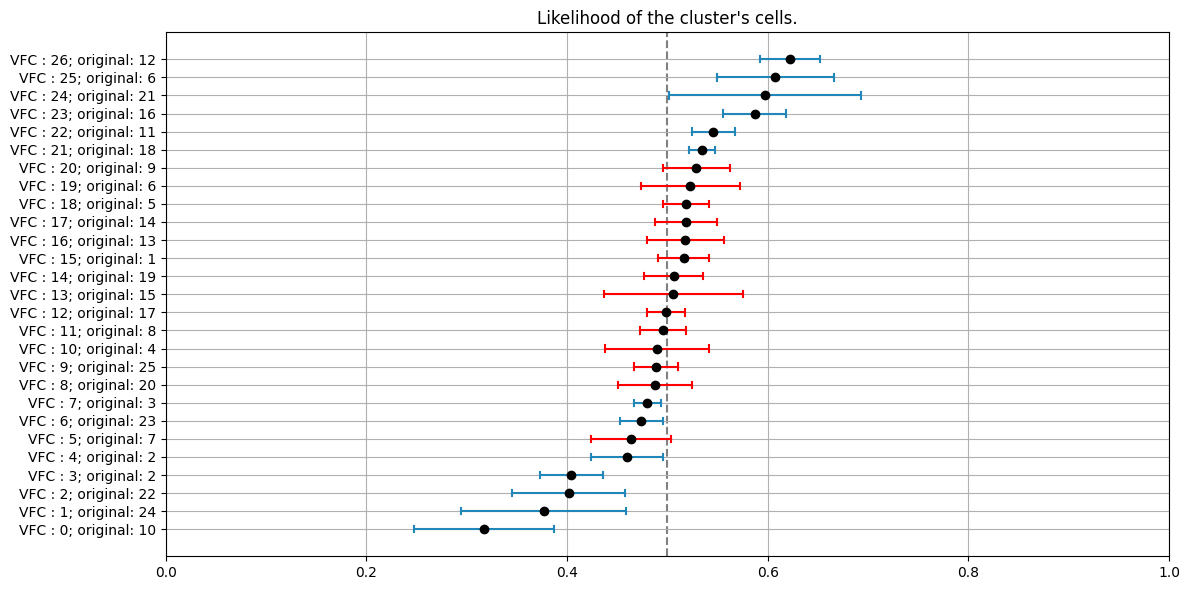

In [258]:
# ax = scprep.plot.jitter(metadata['VFC'], metadata['cond_likelihood'], c=metadata['orig.ident'],
#                         cmap={1:"red",0:"blue"}, figsize=(18,7), legend=False)
# ax.set_ylim(0,1)
# ax.axhline(0.5, linestyle = '--', color='grey', zorder=0)

plt.figure(figsize = (12,6))
clusters, counts = np.unique(metadata[clustering], return_counts=True)

for pred in np.unique(metadata["VFC"]):
    plot_confidence_interval(pred, metadata.loc[metadata["VFC"] == pred, "cond_likelihood"])

plt.axvline(0.5, linestyle = '--', color='grey', zorder=0)

plt.grid(visible=True)
plt.xlim(0,1)

ylabel = [f"VFC : {idx}; original: {clust}" for idx, clust in metadata.set_index("VFC")[clustering][~metadata.set_index("VFC")[clustering].index.duplicated(keep='first')].items()]
plt.yticks(metadata["VFC"].drop_duplicates(), ylabel)

plt.title("Likelihood of the cluster's cells.")
plt.tight_layout()

In [225]:
genes_of_interest = ["Tbx1","Sema3c","Tbx5","Isl1","Fgf10"]

VFC clustering is a way to compare the different response in the cells inside the same cluster, indicating more precise tissues => usefulness when atlas integration ?